
- **Ledoit–Wolf shrinkage** for covariance robust Sigma estimate
- **Black–Litterman**  to blend prior returns with views / market caps
- **Discrete weights** encoding (binary fixed-point) or simple selection encoding
- **Sector caps**, **cardinality**, and **turnover** penalties in QUBO
- **Warm-start** hinting and guidance for custom XY-mixers 
- **Dinkelbach** loop to convert Sharpe ratio into quadratic subproblems
- **Subset tangency** refinement and transaction-cost-aware Sharpe evaluation



In [18]:

import numpy as np, pandas as pd, math, warnings, os
from typing import List, Tuple, Dict, Optional
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit.primitives import Sampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import SPSA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer


from docplex.mp.model import Model


import yfinance as yf


In [2]:

# ===== CONFIG =====+++++++++++++++++++++======================++++++++++++++++==================================
CFG = {
    'tickers': ['AAPL','MSFT','GOOGL','AMZN','NVDA','META','TSLA','AMD','CRM','AVGO'],
    'period': '1y',
    'interval': '1d',
    'risk_free': 0.02,
    'K': 5,                     # cardinality
    'bits_per_asset': 2,        # for discrete weights encoding (binary fixed-point)
    'weight_step': 0.05,        # unary alternative step size
    'use_discrete_weights': False, # if True uses multi-bit weight encoding; else selection (0/1)
    'max_weight': 0.5,          # cap per asset in discrete mode
    'dinkelbach_iters': 4,
    'p_list': [1,2], 'shots': 2048, 'seed': 123,
    'shrink_leduit_wolf': True,
    'bl_enabled': False,        # Black-Litterman
    'sector_caps': {},         # {'Tech':([0,1,4],3)}
    'prev_selection': None,     # list of 0/1 previous picks for turnover penalty
    'lambda_ham': 0.1,          # turnover penalty strength
    'transaction_cost': 0.001,  # per-dollar transaction cost (for turnover-aware Sharpe)
}



## Ledoit–Wolf shrinkage 
compute the LW shrinkage target as the diagonal matrix and compute alpha following a basic Ledoit–Wolf closed form for small samples.


In [3]:

def ledoit_wolf_shrinkage(Sigma_sample: np.ndarray, returns: np.ndarray):
    
    n = Sigma_sample.shape[0]
    T = returns.shape[0]
    sample = Sigma_sample.copy()
    mu = np.diag(sample).mean()
    F = np.eye(n) * mu
   
    X = returns - returns.mean(axis=0, keepdims=True)
    pi_hat = 0.0
    for t in range(T):
        xt = X[t:t+1].T @ X[t:t+1]
        pi_hat += np.sum((xt - sample) ** 2)
    pi_hat /= T
    
    rho_hat = np.sum((sample - F) ** 2)
    
    gamma = np.linalg.norm(sample - F, 'fro')**2
    
    kappa = (pi_hat - rho_hat) / gamma if gamma > 0 else 0.0
    alpha = max(0.0, min(1.0, kappa / T))
    Sigma_shrunk = (1 - alpha) * sample + alpha * F
    return Sigma_shrunk, alpha



## Black–Litterman 
compute an implied prior from market caps or user-supplied prior and blend with views P, Q.


In [4]:

def black_litterman(mu_prior: np.ndarray, Sigma: np.ndarray, P: Optional[np.ndarray], Q: Optional[np.ndarray],
                    tau: float = 0.05, omega: Optional[np.ndarray] = None):
    #  b BL posterior mean (returns)
    n = len(mu_prior)
    if P is None or Q is None:
        return mu_prior
    if omega is None:
        omega = np.diag(np.diag(P @ (tau * Sigma) @ P.T))
    A = np.linalg.pinv(tau * Sigma)
    middle = A + P.T @ np.linalg.pinv(omega) @ P
    rhs = A @ mu_prior + P.T @ np.linalg.pinv(omega) @ Q
    mu_bl = np.linalg.pinv(middle) @ rhs
    return mu_bl



## Data fetch and preprocessing annualize returns and covariance


In [5]:

def fetch_and_prepare(tickers, period='1y', interval='1d'):
    df = yf.download(tickers, period=period, interval=interval, auto_adjust=True, progress=False)['Close']
    if isinstance(df, pd.Series):
        df = df.to_frame()
    df = df.dropna(how='all').ffill().dropna(axis=1)
    rets = df.pct_change().dropna()
    mu_d = rets.mean().values
    Sigma_d = rets.cov().values
    mu = mu_d * 252.0
    Sigma = Sigma_d * 252.0
    return df, rets.values, mu, Sigma

prices, rets_daily, mu, Sigma = fetch_and_prepare(CFG['tickers'], CFG['period'], CFG['interval'])
n = len(mu)
print('Tickers:', CFG['tickers'])
print('mu (annual):', np.round(mu,4))


Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'AMD', 'CRM', 'AVGO']
mu (annual): [0.0735 0.2688 0.3545 0.8232 0.0232 0.2985 0.4433 0.2512 0.508  0.7861]


In [6]:


if CFG['shrink_leduit_wolf']:
    Sigma_sh, alpha = ledoit_wolf_shrinkage(Sigma, rets_daily)
    print('Ledoit-Wolf alpha:', round(alpha,5))
    Sigma = Sigma_sh


Ledoit-Wolf alpha: 0.00142



## Encoding options
- **Selection mode**: x_i ∈ {0,1} — pick asset or not (equal weights or refine later)
- **Discrete weights (binary fixed-point)**: use `bits_per_asset` per asset to encode weights up to `max_weight`.
Note: discrete weights blow up qubit count: n * bits_per_asset qubits.


In [7]:

def binary_encoding_vars(n, bits_per_asset):
    # returns total bits and mapping asset->bit indices
    total_bits = n * bits_per_asset
    mapping = {i: list(range(i*bits_per_asset, (i+1)*bits_per_asset)) for i in range(n)}
    return total_bits, mapping

def weight_from_bits(y_bits: np.ndarray, mapping: Dict[int, List[int]], bits_per_asset: int, max_weight: float):
    # interpret bits as unsigned integer and scale to [0, max_weight]
    n = len(mapping)
    w = np.zeros(n)
    for i in range(n):
        inds = mapping[i]
        val = 0
        for b_idx, bitpos in enumerate(inds):
            val += int(y_bits[bitpos]) * (2**b_idx)
        max_int = 2**bits_per_asset - 1
        w[i] = (val / max_int) * max_weight if max_int>0 else 0.0
    return w



## QUBO builder: supports selection mode or discrete-weight binary encoding.
includes penalties for cardinality, sector caps, and turnover/transaction cost.


In [8]:

def build_qubo_selection(mu, Sigma, rf, K, t_param, A_card, sector_caps, A_sec, x_prev, lambda_ham, trans_cost):
    r = mu - rf
    n = len(r)
    mdl = Model('select_qubo')
    x = mdl.binary_var_list(n, name='x')

    lin = mdl.sum(r[i] * x[i] for i in range(n))
    quad_risk = mdl.sum(Sigma[i,j] * x[i] * x[j] for i in range(n) for j in range(n))
    obj = lin - (t_param / K) * quad_risk

    # cardinality
    sumx = mdl.sum(x)
    obj -= A_card * (sumx - K) * (sumx - K)

    # sector caps
    for name, (idxs, cap) in sector_caps.items():
        if len(idxs)==0: continue
        sx = mdl.sum(x[i] for i in idxs)
        obj -= A_sec * (sx - cap) * (sx - cap)

    # turnover penalty (Hamming distance) and transaction cost approximation
    if x_prev is not None:
        for i in range(n):
            prev = int(x_prev[i])
            # penalize changes: cost ~ lambda_ham*(x_i + prev - 2 x_i * prev) and tx cost proportional
            obj -= lambda_ham * (x[i] + prev - 2 * x[i] * prev)
            if not prev and trans_cost>0:
                
                obj -= trans_cost * (1.0/K) * x[i]
    mdl.maximize(obj)
    qp = QuadraticProgram()
    qp = QuadraticProgram.from_docplex(mdl) if hasattr(QuadraticProgram, 'from_docplex') else QuadraticProgram()
    # safe convert via qiskit_optimization.translators if needed
    try:
        from qiskit_optimization.translators import from_docplex_mp
        qp = from_docplex_mp(mdl)
    except Exception:
        
        pass
    return qp

def build_qubo_binary_weights(mu, Sigma, rf, bits_per_asset, max_weight, t_param, A_budget, budget_val, sector_caps, A_sec, x_prev, lambda_ham, trans_cost):
    
    n = len(mu)
    total_bits, mapping = binary_encoding_vars(n, bits_per_asset)
    mdl = Model('binary_weight_qubo')
    y = mdl.binary_var_list(total_bits, name='y')

    # weight_i = (sum 2^b y_b) / (2^L -1) * max_weight
    max_int = 2**bits_per_asset - 1
    scale = max_weight / max_int if max_int>0 else 0.0

    # linear return term: r^T w
    r = mu - rf
    lin = mdl.sum( r[i] * scale * mdl.sum( (2**(b_idx)) * y[b_idx_global] 
                                          for b_idx, b_idx_global in enumerate(mapping[i]) ) 
                  for i in range(n) )

    
    quad = mdl.sum( (scale * (2**(b_idx)) * (scale * (2**(b_jdx)))) * Sigma[i,j] * y[b_idx_global] * y[b_jdx_global]
                    for i in range(n) for j in range(n)
                    for b_idx, b_idx_global in enumerate(mapping[i])
                    for b_jdx, b_jdx_global in enumerate(mapping[j]) )

    obj = lin - t_param * quad

    
    
    sumw = mdl.sum( scale * mdl.sum((2**b_idx) * y[b_idx_global] for b_idx, b_idx_global in enumerate(mapping[i])) for i in range(n))
    obj -= A_budget * (sumw - budget_val) * (sumw - budget_val)

    
    for name, (idxs, cap) in sector_caps.items():
        
        cap_bits = int(np.ceil(cap / max_weight * (2**bits_per_asset - 1))) * len(idxs)
        sx = mdl.sum(y[b] for i in idxs for b in mapping[i])
        obj -= A_sec * (sx - cap_bits) * (sx - cap_bits)

    
    if x_prev is not None:
        
        for i in range(n):
            prev = int(x_prev[i])
            msb_idx = mapping[i][-1]
            obj -= lambda_ham * ( y[msb_idx] + prev - 2 * y[msb_idx] * prev )
    mdl.maximize(obj)
    try:
        from qiskit_optimization.translators import from_docplex_mp
        qp = from_docplex_mp(mdl)
    except Exception:
        qp = QuadraticProgram()
    return qp



## QAOA solver (Aer sampler) and Dinkelbach loop
inner solver for each Dinkelbach t parameter.


In [9]:

def qaoa_solve_qp(qp: QuadraticProgram, p_list, shots, seed):
    qubo = QuadraticProgramToQubo().convert(qp)
    sampler = Sampler(options={'seed':seed, 'shots':shots})
    best=None; best_res=None
    for p in p_list:
        qaoa = QAOA(sampler=sampler, reps=int(p), optimizer=SPSA(maxiter=120, blocking=True))
        solver = MinimumEigenOptimizer(qaoa)
        try:
            res = solver.solve(qubo)
        except Exception as e:
            print('QAOA solver failed:', e)
            continue
        # extract bits into vector
        x = np.array([int(res.variables_dict[k]) for k in sorted(res.variables_dict.keys(), key=lambda s: int(s.split('_')[-1]))])
        val = qubo.objective.evaluate(res.variables_dict)
        cand={'x':x,'p':p,'energy':val,'raw':res}
        if (best is None) or (val>best['energy']):
            best=cand; best_res=res
    return best, best_res

def dinkelbach_qaoa_runner(mu, Sigma, rf, CFG):
    use_discrete = CFG['use_discrete_weights']
    n = len(mu)
    
    x0 = baseline_greedy(mu, Sigma, CFG['K'], rf)['x']
    w0 = equal_weights_from_x(x0)
    r = mu - rf
    t = float((r @ w0) / max(w0 @ Sigma @ w0, 1e-12))
    best_overall = None; history=[]
    lam_max = float(np.linalg.eigvalsh(Sigma).max())
    for it in range(CFG['dinkelbach_iters']):
        A_card = 10.0 * (t / CFG['K']) * lam_max
        A_sec = 5.0 * (t / CFG['K']) * lam_max
        if not use_discrete:
            qp = build_qubo_selection(mu, Sigma, rf, CFG['K'], t, A_card, CFG['sector_caps'], A_sec, CFG['prev_selection'], CFG['lambda_ham'], CFG['transaction_cost'])
        else:
            qp = build_qubo_binary_weights(mu, Sigma, rf, CFG['bits_per_asset'], CFG['max_weight'], t, A_card, 1.0, CFG['sector_caps'], A_sec, CFG['prev_selection'], CFG['lambda_ham'], CFG['transaction_cost'])
        best, raw = qaoa_solve_qp(qp, CFG['p_list'], CFG['shots'], CFG['seed'])
        if best is None:
            print('No valid QAOA result at iter', it); break
        x = best['x']
        
        if not use_discrete:
            w_eq = equal_weights_from_x(x)
            numer = float((mu - rf) @ w_eq); denom = float(w_eq @ Sigma @ w_eq)
            s_eq = sharpe(w_eq, mu, Sigma, rf)
            t_new = numer / max(denom, 1e-12)
        else:
           
            total_bits, mapping = binary_encoding_vars(n, CFG['bits_per_asset'])
            w = weight_from_bits(x, mapping, CFG['bits_per_asset'], CFG['max_weight'])
           
            if w.sum() > 0:
                w = w / w.sum()
            else:
                w = np.zeros(n)
            w_eq = w; s_eq = sharpe(w_eq, mu, Sigma, rf)
            numer = float((mu - rf) @ w_eq); denom = float(w_eq @ Sigma @ w_eq)
            t_new = numer / max(denom, 1e-12)
        history.append({'iter':it, 't':t, 't_new':t_new, 'x':x, 'w_eq':w_eq, 'sharpe_eq':s_eq})
        if best_overall is None or s_eq > best_overall['sharpe_eq']:
            best_overall = history[-1]
        if abs(t_new - t) < 1e-3:
            t = t_new; break
        t = t_new
    return best_overall, history



## Helper functions 


In [10]:

def sharpe(weights, mu, Sigma, rf):
    port_ret = float(weights @ mu)
    port_var = float(weights @ Sigma @ weights)
    port_vol = math.sqrt(max(port_var, 1e-12))
    return (port_ret - rf) / (port_vol if port_vol>0 else 1e-12)

def equal_weights_from_x(x):
    idx = np.flatnonzero(x)
    if len(idx)==0: return None
    w = np.zeros_like(x, dtype=float)
    w[idx] = 1.0/len(idx)
    return w

def subset_tangency(mu, Sigma, rf, x):
    S = np.flatnonzero(x)
    if len(S)==0: return None
    Sigma_SS = Sigma[np.ix_(S,S)]; r_S = mu[S] - rf
    inv = np.linalg.pinv(Sigma_SS)
    w_S = inv @ r_S
    denom = np.ones(len(S)) @ w_S
    if abs(denom)<1e-12: return None
    w_S = w_S / denom
    w = np.zeros(len(mu)); w[S]=w_S
    return w

def baseline_greedy(mu, Sigma, K, rf, lamb=4.0):
    diag = np.diag(Sigma); r = mu - rf; scores = r - lamb * diag
    pick = np.argsort(scores)[::-1][:K]
    x = np.zeros_like(mu, dtype=int); x[pick]=1
    w = equal_weights_from_x(x); s = sharpe(w, mu, Sigma, rf)
    return {'name':'greedy','x':x,'w':w,'sharpe':s}

def baseline_tangency(mu, Sigma, rf):
    r = mu - rf; inv = np.linalg.pinv(Sigma); w = inv @ r
    denom = np.ones_like(r) @ w
    if abs(denom)<1e-12: return {'name':'tangency','w':None,'sharpe':float('nan')}
    w = w / denom; return {'name':'tangency','w':w,'sharpe':sharpe(w, mu, Sigma, rf)}


In [11]:


greedy_res = baseline_greedy(mu, Sigma, CFG['K'], CFG['risk_free'])
tangency_res = baseline_tangency(mu, Sigma, CFG['risk_free'])
print('Greedy Sharpe:', round(greedy_res['sharpe'],4))
print('Tangency Sharpe:', round(tangency_res['sharpe'],4))


best_overall, history = dinkelbach_qaoa_runner(mu, Sigma, CFG['risk_free'], CFG)
print('\nBest QAOA equal-weight Sharpe (from candidate):', round(best_overall['sharpe_eq'],4))
print('Selected indices:', np.flatnonzero(best_overall['x']).tolist())


Greedy Sharpe: 1.0067
Tangency Sharpe: 1.9998

Best QAOA equal-weight Sharpe (from candidate): 1.3819
Selected indices: [2, 3, 5, 6, 7]


{
    "SharpeComparison": {
        "Greedy (eq-w)": 1.0067,
        "QAOA (eq-w)": 1.3819,
        "QAOA + Refine": 1.4922,
        "Tangency (no card)": 1.9998
    },
    "SelectedTickers": [
        "GOOGL",
        "AMZN",
        "META",
        "TSLA",
        "AMD"
    ],
    "RefinedWeights": {
        "GOOGL": -0.0985,
        "AMZN": 0.5527,
        "META": 0.128,
        "TSLA": 0.5238,
        "AMD": -0.106
    }
}


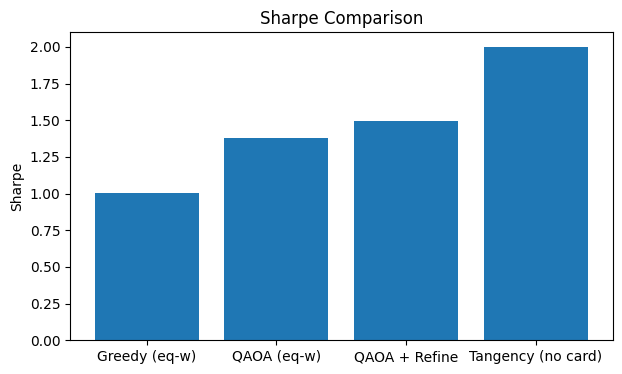

In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt

# --- Refined Sharpe ---
w_refined = subset_tangency(mu, Sigma, CFG['risk_free'], best_overall['x'])
s_refined = sharpe(w_refined, mu, Sigma, CFG['risk_free'])

# --- Collect Sharpe values ---
labels = ['Greedy (eq-w)', 'QAOA (eq-w)', 'QAOA + Refine', 'Tangency (no card)']
values = [greedy_res['sharpe'], best_overall['sharpe_eq'], s_refined, tangency_res['sharpe']]

# --- Selected tickers ---
sel = np.flatnonzero(best_overall['x']).tolist()
selected_tickers = [CFG['tickers'][i] for i in sel]

# --- Refined weights dict ---
refined_weights = {
    CFG['tickers'][i]: round(float(w_refined[i]), 4)
    for i in range(len(CFG['tickers']))
    if w_refined[i] != 0
}

# --- Build JSON object ---
result_json = {
    "SharpeComparison": {
        labels[i]: round(float(values[i]), 4)
        for i in range(len(labels))
    },
    "SelectedTickers": selected_tickers,
    "RefinedWeights": refined_weights
}

# Print nicely formatted JSON
print(json.dumps(result_json, indent=4))

# --- Optional: Plot Sharpe Comparison ---
plt.figure(figsize=(7,4))
plt.bar(labels, values)
plt.ylabel('Sharpe')
plt.title('Sharpe Comparison')
plt.show()



## XY-mixers and warm-starts
- Implementing custom mixers (XY mixer) requires building parameterized QAOA-like circuits that preserve Hamming-weight subspace (for cardinality constraints). Qiskit's high-level QAOA API does not expose custom mixers directly; you'd implement a custom variational ansatz using `QuantumCircuit` and `VQE`/`Estimator` primitives or a low-level QAOA builder.
- Warm-starting: use greedy solution to bias initial angles or to modify mixer Hamiltonian to prefer certain qubits. Implement by seeding classical optimizer or appending small local rotations toward greedy state prior to QAOA layers.


In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
import json

budget = 1000  # Default budget

# Use refined weights
weights = np.array(w_refined) / np.sum(w_refined)

# Ensure we have prices
if 'prices' not in CFG:
    print("Fetching latest prices using yfinance...")
    prices = []
    for t in CFG['tickers']:
        data = yf.download(t, period="5d", progress=False)
        # Try Adj Close, else fallback to Close
        if "Adj Close" in data.columns:
            latest_price = data["Adj Close"].iloc[-1]
        elif "Close" in data.columns:
            latest_price = data["Close"].iloc[-1]
        else:
            raise ValueError(f"No valid price column found for {t}")
        prices.append(float(latest_price))   # ensure plain float
    CFG['prices'] = prices
else:
    prices = [float(p) for p in CFG['prices']]  # flatten to float

# Dollar allocation per asset
allocations = weights * budget

# Compute shares + spent + leftover
shares, spent = [], []
for alloc, price in zip(allocations, prices):
    num_shares = int(alloc // price)
    cost = num_shares * price
    shares.append(num_shares)
    spent.append(cost)

total_spent = sum(spent)
leftover_cash = budget - total_spent

# Build JSON structure
portfolio_json = {
    "Portfolio": [
        {
            "Asset": CFG['tickers'][i],
            "Weight": round(float(weights[i]), 4),
            "Price($)": round(float(prices[i]), 2),
            "Allocation($)": round(float(allocations[i]), 2),
            "Shares": int(shares[i]),
            "Spent($)": round(float(spent[i]), 2)
        }
        for i in range(len(CFG['tickers']))
    ],
    "Summary": {
        "Total Spent($)": round(float(total_spent), 2),
        "Leftover Cash($)": round(float(leftover_cash), 2),
        "Budget($)": budget
    }
}

# Print nicely formatted JSON
print(json.dumps(portfolio_json, indent=4))


{
    "Portfolio": [
        {
            "Asset": "AAPL",
            "Weight": 0.0,
            "Price($)": 230.49,
            "Allocation($)": 0.0,
            "Shares": 0,
            "Spent($)": 0.0
        },
        {
            "Asset": "MSFT",
            "Weight": 0.0,
            "Price($)": 506.74,
            "Allocation($)": 0.0,
            "Shares": 0,
            "Spent($)": 0.0
        },
        {
            "Asset": "GOOGL",
            "Weight": -0.0985,
            "Price($)": 207.48,
            "Allocation($)": -98.52,
            "Shares": -1,
            "Spent($)": -207.48
        },
        {
            "Asset": "AMZN",
            "Weight": 0.5527,
            "Price($)": 229.12,
            "Allocation($)": 552.66,
            "Shares": 2,
            "Spent($)": 458.24
        },
        {
            "Asset": "NVDA",
            "Weight": 0.0,
            "Price($)": 181.6,
            "Allocation($)": 0.0,
            "Shares": 0,
            "Spen